In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.ensemble import IsolationForest
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [3]:
def tt(x):
    return torch.Tensor(x)

def normalise(arr, m, s):
    return (arr - m) / s

def denormalise(arr, m, s):
    return s * arr + m

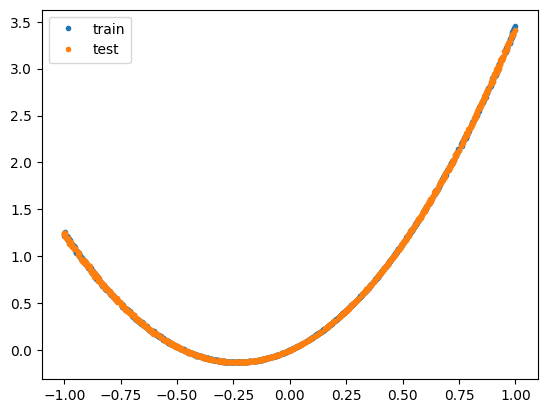

<Figure size 640x480 with 0 Axes>

In [4]:
a_const = 2.34
sigma_a = np.abs(a_const * 0.01)
b_const = 1.1
sigma_b = np.abs(b_const * 0.01)
c_const = 0
sigma_c = np.abs(c_const * 0.01)

n_samples = 2000
n_samples_train = 1000

ranger = np.random.Generator(np.random.PCG64())

x = np.random.uniform(-1, 1, n_samples)
np.random.shuffle(x)
normalise_x = lambda a: normalise(a, np.mean(x), np.std(x))
denormalise_x = lambda a: denormalise(a, np.mean(x), np.std(x))
x_preprocessed = x
# y = x * ranger.normal(a_const, sigma_a, n_samples) + np.random.normal(b_const, sigma_b, n_samples)
y = x * x * np.random.uniform(a_const - sigma_a, a_const + sigma_a, n_samples) + x * np.random.uniform(b_const - sigma_b, b_const + sigma_b, n_samples) + np.random.uniform(c_const - sigma_c, c_const + sigma_c, n_samples)
normalise_y = lambda a: normalise(a, np.mean(y), np.std(y))
denormalise_y = lambda a: denormalise(a, np.mean(y), np.std(y))
y_preprocessed = y
x_train = x_preprocessed[:n_samples_train]
x_test = x_preprocessed[n_samples_train:]
y_train = y_preprocessed[:n_samples_train]
y_test = y_preprocessed[n_samples_train:]


plt.plot(x_train, y_train, '.', label='train')
plt.plot(x_test, y_test, '.', label='test')
# plt.plot([0, 1], [b_const, a_const + b_const])
# plt.plot(np.linspace(0, 1), a_const * np.linspace(0, 1) * np.linspace(0, 1) + b_const * np.linspace(0, 1) + c_const)
plt.legend()
plt.figure()

batch_size = 1
features_train = x_train.reshape(-1, batch_size)
features_test = x_test.reshape(-1, batch_size)
target_train = y_train.reshape(-1, batch_size)
target_test = y_test.reshape(-1, batch_size)


In [5]:
features_train.shape

(1000, 1)

In [6]:
target_train.shape

(1000, 1)

In [7]:
from nn_utils import default_run, load_torch, save_torch, get_total_history

In [8]:
class NeuralNetworkSimple(nn.Module):  
    def __init__(self, input_shape, output_shape):
        super().__init__()
        # self.rnn1 = nn.RNN(input_size=np.prod(input_shape), hidden_size=100, num_layers=2, nonlinearity='tanh', bias=True, batch_first=False, dropout=0.0, bidirectional=False)
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(np.prod(input_shape), 3),
            nn.SiLU(),
            nn.Linear(3, 3),
            nn.SiLU(),
            # nn.Linear(3, 3, bias=False),
            # nn.ReLU(),
            nn.Linear(3, np.prod(output_shape)),
            # nn.Dropout(0.05),
        )


    def forward(self, x):
        # x, hn = self.rnn1(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x



In [9]:
! rm -rf model_states/NeuralNetworkSimple

NeuralNetworkSimple(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1, out_features=3, bias=True)
    (1): SiLU()
    (2): Linear(in_features=3, out_features=3, bias=True)
    (3): SiLU()
    (4): Linear(in_features=3, out_features=1, bias=True)
  )
)


  0%|          | 0/50000 [00:00<?, ?it/s]

loss: 0.054968  [ 5000]


<Figure size 640x480 with 0 Axes>

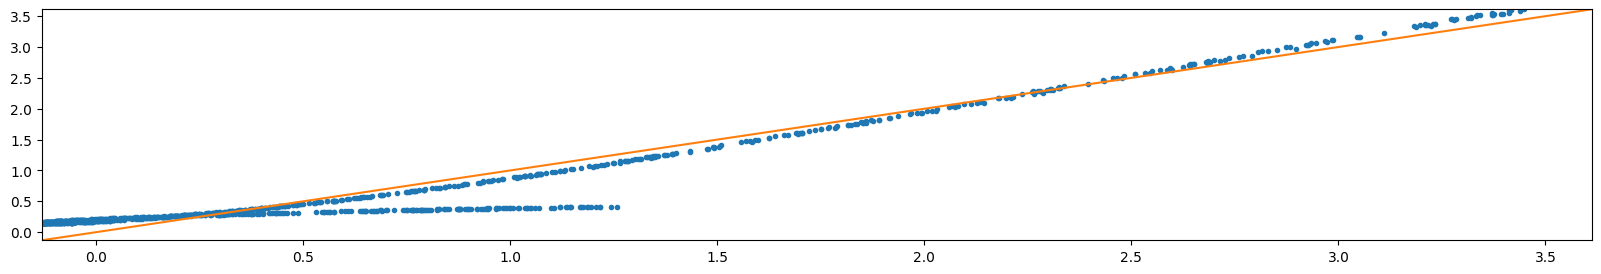

loss: 0.052652  [10000]


<Figure size 640x480 with 0 Axes>

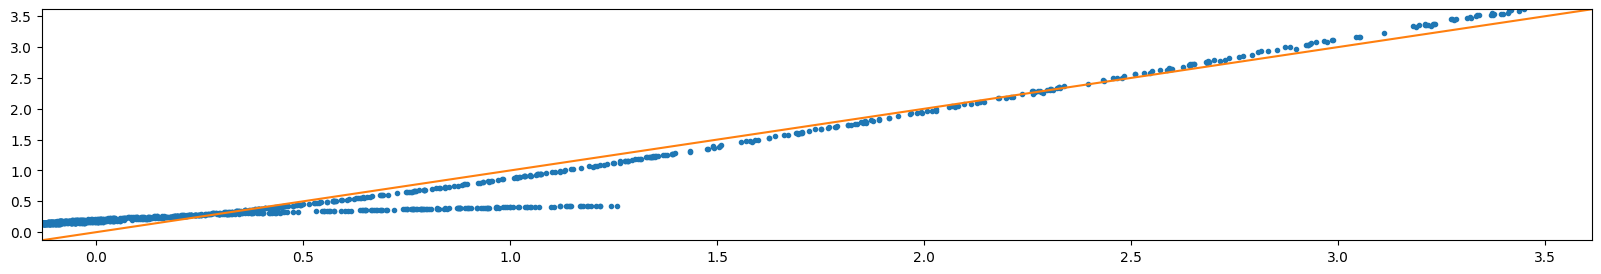

loss: 0.050317  [15000]


<Figure size 640x480 with 0 Axes>

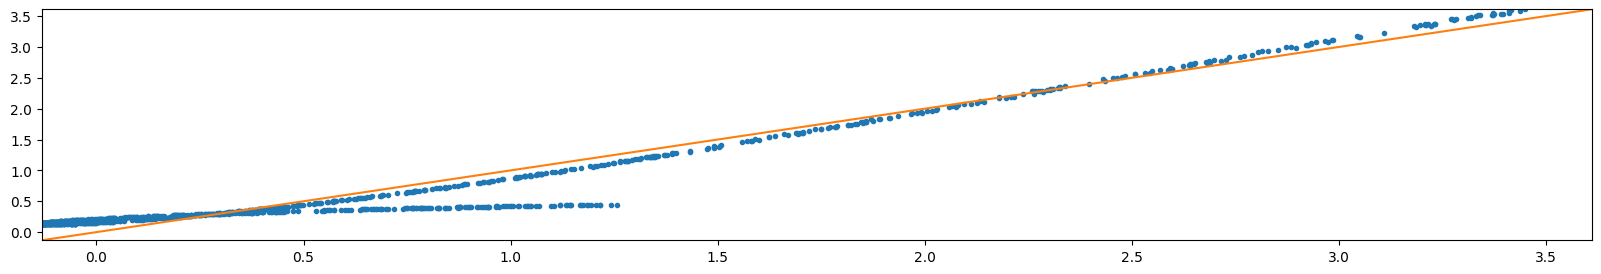

loss: 0.047901  [20000]


<Figure size 640x480 with 0 Axes>

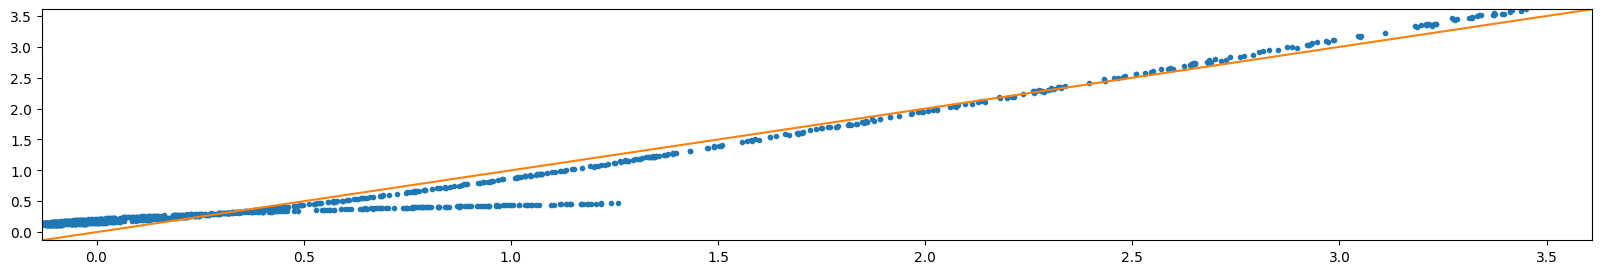

loss: 0.045347  [25000]


<Figure size 640x480 with 0 Axes>

loss: 0.042607  [30000]


<Figure size 640x480 with 0 Axes>

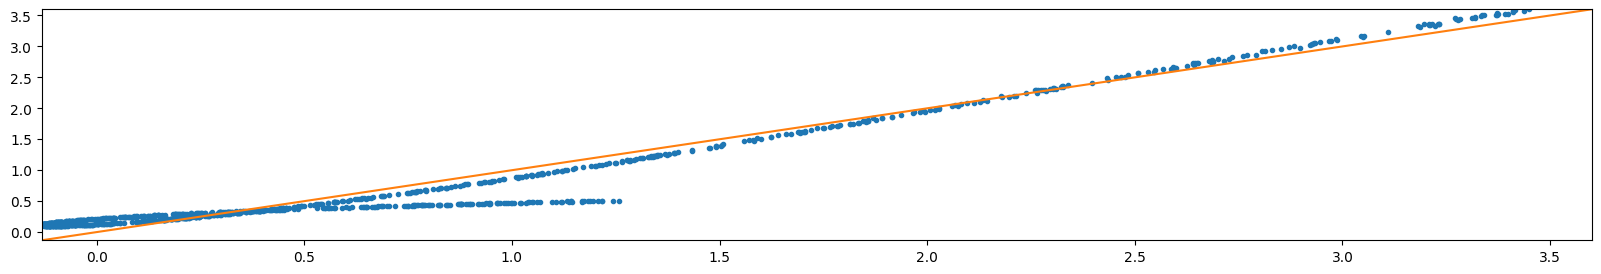

loss: 0.039655  [35000]


<Figure size 640x480 with 0 Axes>

loss: 0.036492  [40000]


<Figure size 640x480 with 0 Axes>

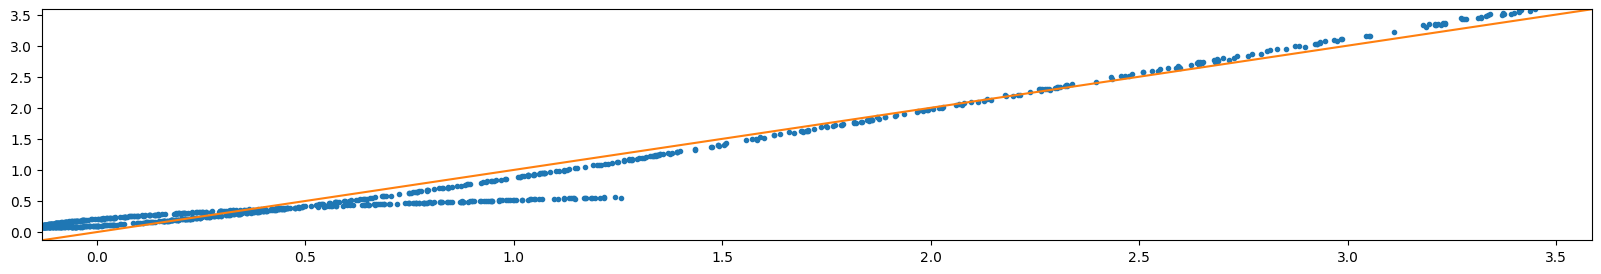

loss: 0.033156  [45000]


<Figure size 640x480 with 0 Axes>

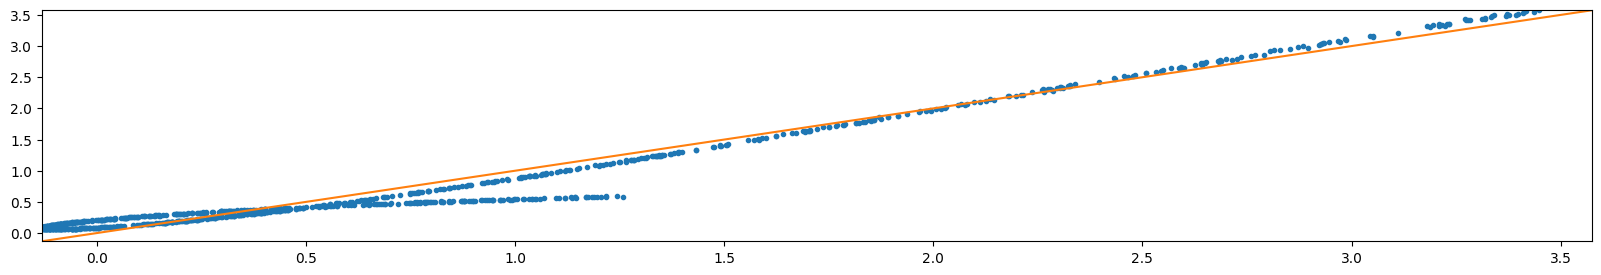

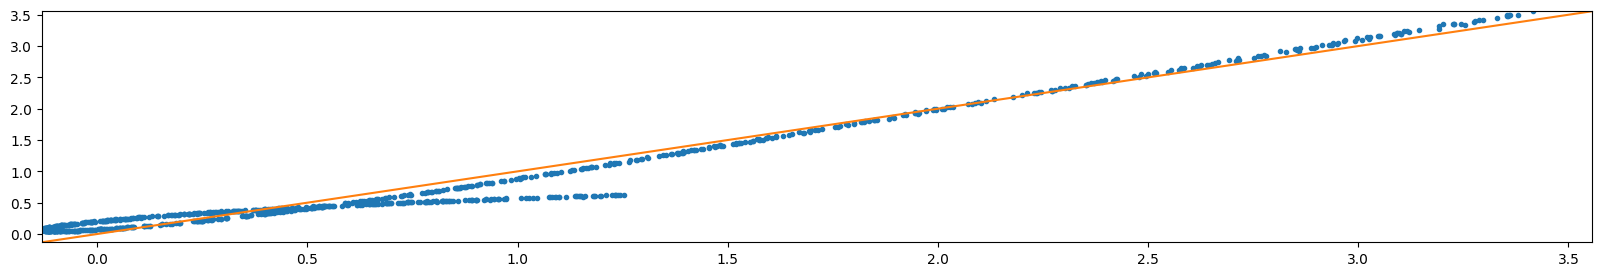

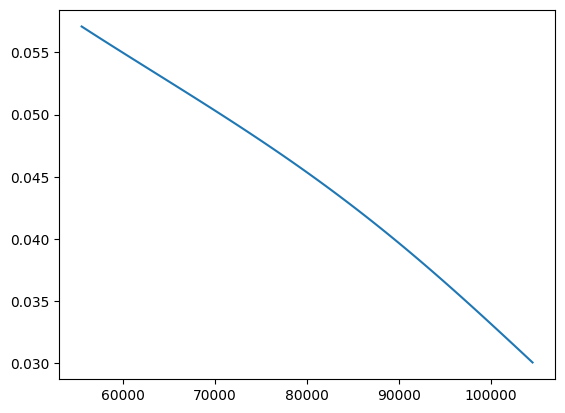

In [22]:
model, trained_epochs = load_torch(NeuralNetworkSimple, dict(input_shape=features_train.shape[1:], output_shape=target_train.shape[1:]))
print(model)
epochs_to_train = 50000
# randomize parameters a bit
# for param in model.parameters():
#     param.data.add_((torch.rand_like(param.data) - 0.5) * 0.1)
history_run = default_run(
    model, tt(features_train), tt(target_train), tt(features_test), tt(target_test), 
    trained_epochs, epochs_to_train, 
    optimizer=torch.optim.SGD, loss_function=nn.MSELoss,
    save_parameters=True)
save_torch(model, trained_epochs + epochs_to_train, history=history_run)

In [23]:
! du -hd1 model_states/NeuralNetworkSimple

880K	model_states/NeuralNetworkSimple


In [24]:
htot = get_total_history('model_states', 'NeuralNetworkSimple')

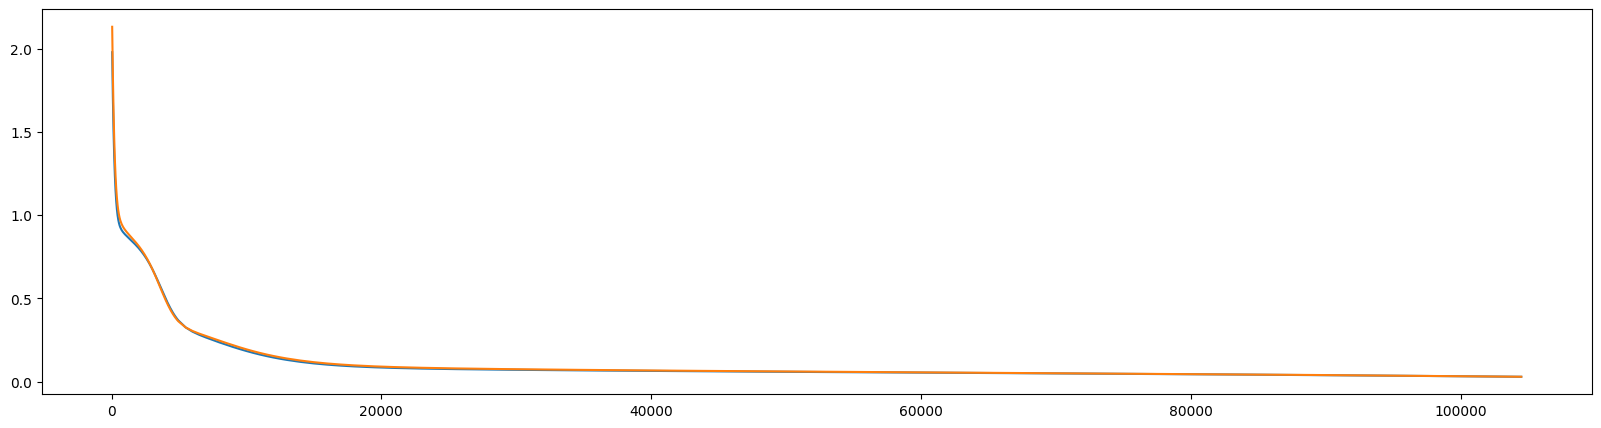

In [25]:
plt.figure(figsize=[20, 5])
plt.plot([h['epoch'] for h in htot], [h['loss'] for h in htot])
# plt.show()

# plt.figure(figsize=[20, 5])
plt.plot([h['epoch'] for h in htot], [h['loss_test'] for h in htot])
plt.show()


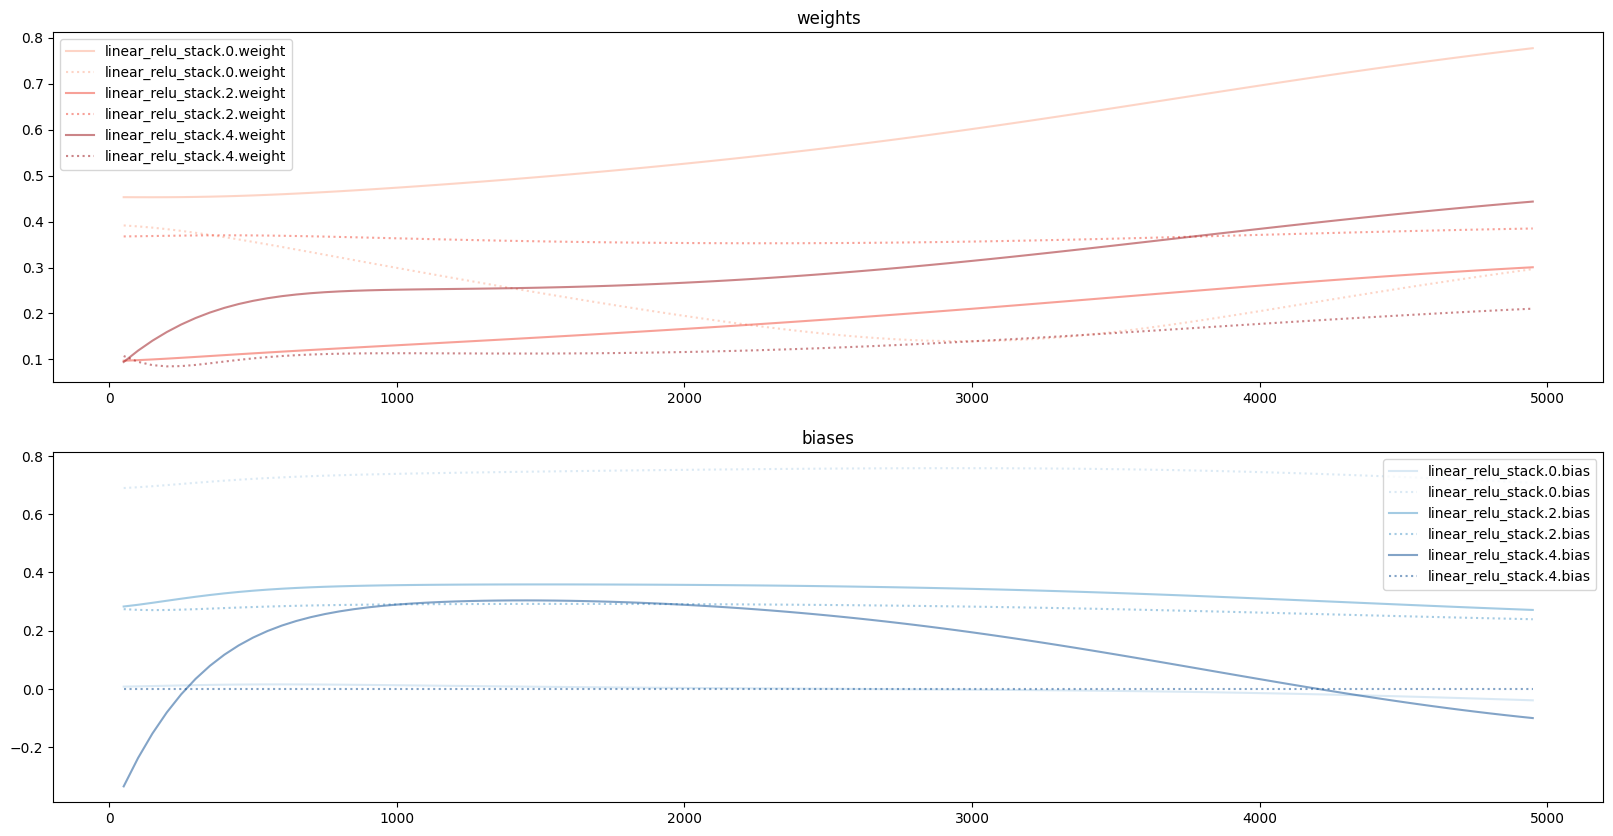

In [14]:
keys = htot[0]['parameters'].keys()
parameters = {k: {'mean': [], 'std': []} for k in keys}

for h in htot:
    for k, v in h['parameters'].items():
        parameters[k]['mean'].append(np.mean(v))
        parameters[k]['std'].append(np.std(v))
    # parameters[k] = np.stack(parameters[k], axis=0).transpose()


fig, ax = plt.subplots(figsize=[20, 10], nrows=2)

nlayers = max([int(k.split('.')[1]) for k in parameters.keys()]) + 1
colors_w = [mpl.colormaps['Reds'](x) for x in np.linspace(0.3, 0.9, num=nlayers)]
colors_b = [mpl.colormaps['Blues'](x) for x in np.linspace(0.3, 0.9, num=nlayers)]

ax[0].set_title('weights')
iw = 0
ax[1].set_title('biases')
ib = 0

for k, v in parameters.items():
    if 'weight' in k:
        axp = ax[0]
        colors = colors_w
    elif 'bias' in k:
        axp = ax[1]
        colors = colors_b

    i = int(k.split('.')[1])
    axp.plot([h['epoch'] for h in htot], v['mean'], c=colors[i], label=k, alpha=0.5)
    axp.plot([h['epoch'] for h in htot], v['std'], ':', c=colors[i], label=k, alpha=0.5)
    # axp.fill_between(
    #     [h['epoch'] for h in htot], 
    #     [x - s/2 for x, s in zip(v['mean'], v['std'])],
    #     [x + s/2 for x, s in zip(v['mean'], v['std'])],
    #     color=colors[i], label=None, alpha=0.5)

    # for iv, values in enumerate(v):
    #     i = int(k.split('.')[1])
    #     axp.plot([h['epoch'] for h in htot], values, c=colors[i], label=k if iv == 0 else None, alpha=0.5)
    
    
ax[0].legend()
ax[1].legend()

plt.show()

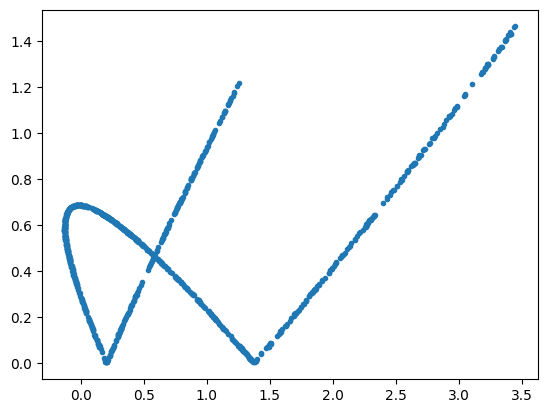

In [15]:
df_compare = (
    pd.DataFrame({'known': target_train.flatten(), 'pred': model(tt(features_train)).flatten().detach().numpy()})
    .assign(delta=lambda x: np.abs(x.known - x.pred))
)

plt.plot(df_compare.known, df_compare.delta, '.')

In [16]:
# plt.matshow(np.transpose([list(h['parameters']) for h in htot]))
# plt.colorbar()
# plt.show()

In [17]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Tensorflow

In [ ]:
import tensorflow as tf

model_tf = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1, 1)),
  tf.keras.layers.Dense(3, activation='relu'),
  tf.keras.layers.Dense(3, activation='relu'),
  tf.keras.layers.Dense(1)
])
loss_fn = tf.keras.losses.MeanAbsoluteError()
model_tf.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
model_tf.fit(features_train, target_train, epochs=250)



In [ ]:
model_tf(features_train)